In [6]:
import pandas as pd

# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71717 entries, 0 to 71716
Columns: 161 entries, Timestamp to Z_Intensity
dtypes: bool(1), float64(117), int64(23), object(20)
memory usage: 87.6+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71717 entries, 0 to 71716
Columns: 161 entries, Timestamp to Z_Intensity
dtypes: bool(1), float64(117), int64(23), object(20)
memory usage: 87.6+ MB


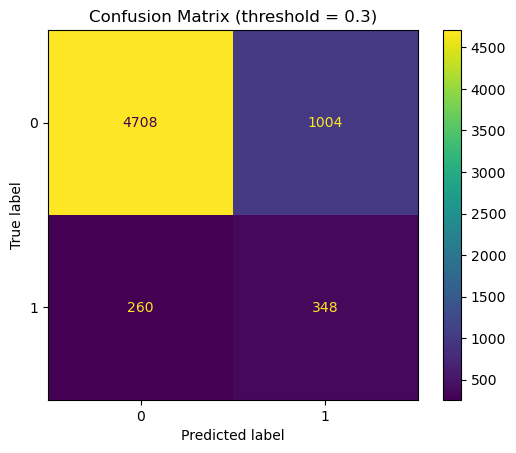

📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9477    0.8242    0.8816      5712
           1     0.2574    0.5724    0.3551       608

    accuracy                         0.8000      6320
   macro avg     0.6025    0.6983    0.6184      6320
weighted avg     0.8813    0.8000    0.8310      6320

📈 Evaluation Metrics:
Accuracy:  0.8000
Precision: 0.2574
Recall:    0.5724
F1 Score:  0.3551
ROC AUC:   0.7924
PR AUC:    0.3210

🔍 Feature Importance (Top 15):
              Feature  Importance
57          Intensity    0.066632
55        Z_Intensity    0.042876
15  mean_intensity_1h    0.041693
44     1_1.5h_pre_std    0.033412
12           Time_24h    0.032642
13    hungry_weighted    0.026752
47     1.5_2h_pre_std    0.026059
14         EMA_T_Diff    0.025125
29         Sleep_Diff    0.024909
16  mean_intensity_2h    0.024882
1        15m_G_Diff_6    0.024792
17  mean_intensity_3h    0.024216
54               Z_HR    0.023685
45   1_1.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")
df.info()

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity"
    
]

# Remove rows with missing values
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
df_model = df_model[~df_model["StudyID"].isin([8, 40, 59, 86])]

X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)

# Split train/test
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE with dynamic k_neighbors
minority_class_size = np.bincount(y_train_raw)[1]
k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

# Predict
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluation
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh)
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_thresh, digits=4))
print("📈 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_thresh):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR AUC:    {average_precision_score(y_test, y_proba):.4f}")

# Feature importance
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n🔍 Feature Importance (Top 15):")
print(importances.head(15))


In [12]:
# Count label occurrences in train set
print("📊 y_train class distribution:")
print(y_train.value_counts())

# Count label occurrences in test set
print("\n📊 y_test class distribution:")
print(y_test.value_counts())


📊 y_train class distribution:
GE_1h
0    22845
1    22845
Name: count, dtype: int64

📊 y_test class distribution:
GE_1h
0    5712
1     608
Name: count, dtype: int64


In [152]:
# Predict on training set
y_train_proba = model.predict_proba(X_train)[:, 1]
y_train_pred_thresh = (y_train_proba >= threshold).astype(int)

print("\n📋 Training Set Classification Report:")
print(classification_report(y_train, y_train_pred_thresh, digits=4))


📋 Training Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9885    0.9942     22845
           1     0.9887    1.0000    0.9943     22845

    accuracy                         0.9943     45690
   macro avg     0.9943    0.9943    0.9943     45690
weighted avg     0.9943    0.9943    0.9943     45690



# Other models

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score
)
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Load data
df = pd.read_csv('/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv', encoding="utf-8")

# Preprocess Time
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

# Define features and labels
X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity"
    
]
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
df_model = df_model[~df_model["StudyID"].isin([8, 40, 59, 86])]
X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)

# Train-test split
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE
minority_class_size = np.bincount(y_train_raw)[1]
k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Models to evaluate
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

threshold = 0.3

# Evaluation
for name, model in models.items():
    print(f"\n🔍 Model: {name}")
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    print("📋 Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("📈 Evaluation Metrics:")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"F1 Score:  {f1_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
    print(f"PR AUC:    {average_precision_score(y_test, y_proba):.4f}")
    print("-" * 60)



🔍 Model: Random Forest
📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9477    0.8242    0.8816      5712
           1     0.2574    0.5724    0.3551       608

    accuracy                         0.8000      6320
   macro avg     0.6025    0.6983    0.6184      6320
weighted avg     0.8813    0.8000    0.8310      6320

📈 Evaluation Metrics:
Accuracy:  0.8000
Precision: 0.2574
Recall:    0.5724
F1 Score:  0.3551
ROC AUC:   0.7924
PR AUC:    0.3210
------------------------------------------------------------

🔍 Model: Gradient Boosting
📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9315    0.6886    0.7918      5712
           1     0.1520    0.5247    0.2358       608

    accuracy                         0.6728      6320
   macro avg     0.5418    0.6066    0.5138      6320
weighted avg     0.8566    0.6728    0.7383      6320

📈 Evaluation Metrics:
Accuracy:  0.6728
Precision: 0.

[02:49:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9282    0.9436    0.9358      5712
           1     0.3723    0.3141    0.3408       608

    accuracy                         0.8831      6320
   macro avg     0.6503    0.6289    0.6383      6320
weighted avg     0.8747    0.8831    0.8786      6320

📈 Evaluation Metrics:
Accuracy:  0.8831
Precision: 0.3723
Recall:    0.3141
F1 Score:  0.3408
ROC AUC:   0.7973
PR AUC:    0.3410
------------------------------------------------------------

🔍 Model: Logistic Regression
📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9763    0.3107    0.4714      5712
           1     0.1255    0.9293    0.2211       608

    accuracy                         0.3703      6320
   macro avg     0.5509    0.6200    0.3463      6320
weighted avg     0.8945    0.3703    0.4474      6320

📈 Evaluation Metrics:
Accuracy:  0.3703
Precision: 0.1255
Recall:    0.9293

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


# No Smote

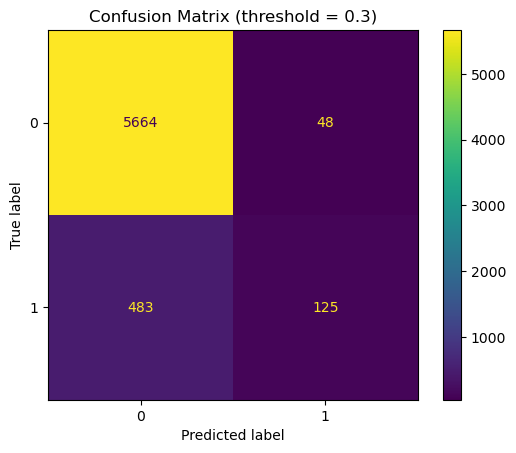

📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9214    0.9916    0.9552      5712
           1     0.7225    0.2056    0.3201       608

    accuracy                         0.9160      6320
   macro avg     0.8220    0.5986    0.6377      6320
weighted avg     0.9023    0.9160    0.8941      6320

📈 Evaluation Metrics:
Accuracy:  0.9160
Precision: 0.7225
Recall:    0.2056
F1 Score:  0.3201
ROC AUC:   0.8420
PR AUC:    0.4417

🔍 Feature Importance (Top 15):
              Feature  Importance
12           Time_24h    0.044574
29         Sleep_Diff    0.036970
14         EMA_T_Diff    0.032812
53       Z_Previous_4    0.031704
54               Z_HR    0.029716
17  mean_intensity_3h    0.029473
15  mean_intensity_1h    0.026318
23          HR_std_3h    0.026221
6        Z_Previous_5    0.025006
22          HR_std_2h    0.024475
27          TimeInBed    0.023753
26        HR_slope_3h    0.023747
16  mean_intensity_2h    0.023664
55       

In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import pandas as pd

# Train 모델 (SMOTE 없이 원래 X_train_raw, y_train_raw 사용)
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train_raw, y_train_raw)

# Predict
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluation
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh)
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_thresh, digits=4))
print("📈 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_thresh):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_thresh):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_thresh):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_thresh):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR AUC:    {average_precision_score(y_test, y_proba):.4f}")

# Feature importance
importances = pd.DataFrame({
    "Feature": X_train_raw.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n🔍 Feature Importance (Top 15):")
print(importances.head(15))


# RandomizedSearchCV

In [191]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score, classification_report, f1_score

# 래퍼 클래스: threshold 기준으로 예측하게 만듦
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, threshold=0.3):
        self.base_model = base_model
        self.threshold = threshold

    def fit(self, X, y):
        self.base_model.fit(X, y)
        return self

    def predict(self, X):
        probas = self.base_model.predict_proba(X)[:, 1]
        return (probas >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.base_model.predict_proba(X)

# 0.3 threshold 기준 recall scorer (클래스 1에 대한)
def threshold_recall_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)

threshold_scorer = make_scorer(threshold_recall_score)

# 파라미터 튜닝 대상 (기존 param_dist 축소판)
param_dist = {
    'base_model__n_estimators': [100, 500, 1000],
    'base_model__max_features': ['sqrt', 'log2', None],
    'base_model__max_depth': [10, 25, 50],
    'base_model__min_samples_split': [20, 50, 100],
    'base_model__min_samples_leaf': [50],
    'base_model__bootstrap': [True],
    'base_model__criterion': ['gini', 'entropy'],
    'base_model__class_weight': [None]
}

# 모델 정의
base_rf = RandomForestClassifier(random_state=42)
threshold_model = ThresholdClassifier(base_model=base_rf, threshold=0.3)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    threshold_model,
    param_distributions=param_dist,
    scoring=threshold_scorer,
    n_iter=30,
    cv=3,
    verbose=10,
    random_state=42,
    n_jobs=-1
)

# 학습
random_search.fit(X_train, y_train)

# 결과
print("🔍 Best Hyperparameters:")
print(random_search.best_params_)

# 평가
best_model = random_search.best_estimator_
y_pred_thresh = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n📋 Classification Report (Best Model with threshold = 0.3):")
print(classification_report(y_test, y_pred_thresh, digits=4))
print(f"F1 Score: {f1_score(y_test, y_pred_thresh):.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=50, base_model__max_features=None, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=1000
[CV 1/3; 1/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=50, base_model__max_features=None, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=1000;, score=nan total time=14.9min
[CV 2/3; 16/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=gini, base_model__max_depth=25, base_model__max_features=sqrt, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=100
[CV 2/3; 16/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=gini, base_model_

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/envs/jupyt

[CV 2/3; 1/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=50, base_model__max_features=None, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=1000
[CV 2/3; 1/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=50, base_model__max_features=None, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=1000;, score=nan total time=13.4min
[CV 3/3; 10/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=50, base_model__max_features=log2, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=100
[CV 3/3; 10/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=50, base_model__max_features=log2, base_mode

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/envs/jupyt

[CV 3/3; 2/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=25, base_model__max_features=sqrt, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=500
[CV 3/3; 2/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=25, base_model__max_features=sqrt, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=500;, score=nan total time=  54.5s
[CV 3/3; 4/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=gini, base_model__max_depth=50, base_model__max_features=sqrt, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=500
[CV 3/3; 4/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=gini, base_model__max_depth=50, base_model__max_features=sqrt, base_model__min_sam

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/envs/jupyt

[CV 3/3; 1/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=50, base_model__max_features=None, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=1000
[CV 3/3; 1/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=50, base_model__max_features=None, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=1000;, score=nan total time=13.3min
[CV 2/3; 10/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=50, base_model__max_features=log2, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=100
[CV 2/3; 10/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=50, base_model__max_features=log2, base_mode

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/envs/jupyt

[CV 1/3; 2/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=25, base_model__max_features=sqrt, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=500
[CV 1/3; 2/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=25, base_model__max_features=sqrt, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=500;, score=nan total time=  58.0s
[CV 2/3; 5/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=10, base_model__max_features=log2, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=500
[CV 2/3; 5/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=10, base_model__max_features=log2, base_model__m

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/envs/jupyt

[CV 1/3; 4/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=gini, base_model__max_depth=50, base_model__max_features=sqrt, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=500
[CV 1/3; 4/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=gini, base_model__max_depth=50, base_model__max_features=sqrt, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=500;, score=nan total time=  48.0s
[CV 2/3; 4/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=gini, base_model__max_depth=50, base_model__max_features=sqrt, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=500
[CV 2/3; 4/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=gini, base_model__max_depth=50, base_model__max_features=sqrt, base_model__min_samples_l

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/envs/jupyt

[CV 2/3; 3/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=25, base_model__max_features=None, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=1000
[CV 2/3; 3/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=25, base_model__max_features=None, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=1000;, score=nan total time=13.1min
[CV 3/3; 9/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=10, base_model__max_features=None, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=500
[CV 3/3; 9/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=10, base_model__max_features=None, base_model_

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/envs/jupyt

[CV 3/3; 3/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=25, base_model__max_features=None, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=1000
[CV 3/3; 3/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=25, base_model__max_features=None, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=1000;, score=nan total time=13.3min
[CV 1/3; 10/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=50, base_model__max_features=log2, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=100
[CV 1/3; 10/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=50, base_model__max_features=log2, base_mode

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/envs/jupyt

[CV 1/3; 3/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=25, base_model__max_features=None, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=1000
[CV 1/3; 3/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=25, base_model__max_features=None, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=1000;, score=nan total time=14.8min
[CV 1/3; 16/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=gini, base_model__max_depth=25, base_model__max_features=sqrt, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=100
[CV 1/3; 16/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=gini, base_model__max_depth=25, base_model__max_features=sqrt, base_model__min

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/envs/jupyt

[CV 2/3; 2/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=25, base_model__max_features=sqrt, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=500
[CV 2/3; 2/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=25, base_model__max_features=sqrt, base_model__min_samples_leaf=50, base_model__min_samples_split=20, base_model__n_estimators=500;, score=nan total time=  55.0s
[CV 1/3; 5/30] START base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=10, base_model__max_features=log2, base_model__min_samples_leaf=50, base_model__min_samples_split=50, base_model__n_estimators=500
[CV 1/3; 5/30] END base_model__bootstrap=True, base_model__class_weight=None, base_model__criterion=entropy, base_model__max_depth=10, base_model__max_features=log2, base_model__m

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/envs/jupyt

🔍 Best Hyperparameters:
{'base_model__n_estimators': 1000, 'base_model__min_samples_split': 50, 'base_model__min_samples_leaf': 50, 'base_model__max_features': None, 'base_model__max_depth': 50, 'base_model__criterion': 'entropy', 'base_model__class_weight': None, 'base_model__bootstrap': True}

📋 Classification Report (Best Model with threshold = 0.3):
              precision    recall  f1-score   support

           0     0.9471    0.7454    0.8342      5712
           1     0.2029    0.6086    0.3043       608

    accuracy                         0.7323      6320
   macro avg     0.5750    0.6770    0.5693      6320
weighted avg     0.8755    0.7323    0.7833      6320

F1 Score: 0.3043


In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, average_precision_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 데이터 불러오기
df = pd.read_csv("/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/order_add2.csv")

# 시간 변환
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

# 피처 목록
X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4"
    
]
# 결측 및 제외 대상 제거
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
df_model = df_model[~df_model["StudyID"].isin([8, 40, 59, 86])]

X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)

# backward feature elimination
X_current = X.copy()
features = X_columns.copy()
performance_log = []

while len(features) > 1:
    # Train/Test split
    X_train_raw, X_test, y_train_raw, y_test = train_test_split(X_current, y, stratify=y, test_size=0.2, random_state=42)
    
    # SMOTE
    minority = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority - 1) if minority > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # 모델 학습
    model = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=None,
    criterion='entropy',
    class_weight='balanced',
    bootstrap=True,
    random_state=42
)
    model.fit(X_train, y_train)

    
    # 예측 및 평가
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.3).astype(int)
    recall = recall_score(y_test, y_pred, zero_division=0)
    pr_auc = average_precision_score(y_test, y_proba)

    # 기록
    performance_log.append({
        "n_features": len(features),
        "removed_feature": None,
        "recall": recall,
        "pr_auc": pr_auc,
        "features": features.copy()
    })

    # 가장 덜 중요한 feature 제거
    importances = model.feature_importances_
    min_idx = np.argmin(importances)
    removed_feature = features.pop(min_idx)
    X_current = X_current[features]
    performance_log[-1]["removed_feature"] = removed_feature

# 결과 저장
results_df = pd.DataFrame(performance_log)



In [21]:
# recall 기준 내림차순 정렬
results_sorted = results_df.sort_values(by="recall", ascending=False).reset_index(drop=True)

results_sorted

,n_features,removed_feature,recall,pr_auc,features
0,2,1_1.5h_pre_std,0.611193,0.116770,"[mean_intensity_1h, 1_1.5h_pre_std]"
1,54,TimeInBed_isnull,0.553756,0.319202,"[15m_G_Diff_5, 15m_G_Diff_6, 15m_G_Diff_7, 15m..."
2,47,How_anxious_weighted_isnull,0.540501,0.315464,"[15m_G_Diff_5, 15m_G_Diff_6, 15m_G_Diff_7, 15m..."
3,53,Sleep_Diff_isnull,0.531664,0.322007,"[15m_G_Diff_5, 15m_G_Diff_6, 15m_G_Diff_7, 15m..."
4,50,bored_weighted_isnull,0.527246,0.317679,"[15m_G_Diff_5, 15m_G_Diff_6, 15m_G_Diff_7, 15m..."
5,46,Glucose_std_pre_1_2.5h,0.527246,0.314323,"[15m_G_Diff_5, 15m_G_Diff_6, 15m_G_Diff_7, 15m..."
6,48,How_stressed_weighted_isnull,0.522828,0.313287,"[15m_G_Diff_5, 15m_G_Diff_6, 15m_G_Diff_7, 15m..."
7,52,Efficiency_isnull,0.519882,0.311830,"[15m_G_Diff_5, 15m_G_Diff_6, 15m_G_Diff_7, 15m..."
8,45,Glucose_spread_ratio_pre_1_2.5h,0.509573,0.314121,"[15m_G_Diff_5, 15m_G_Diff_6, 15m_G_Diff_7, 15m..."
9,43,1_1.5h_pre_mean,0.506627,0.312274,"[15m_G_Diff_5, 15m_G_Diff_6, 15m_G_Diff_7, 15m..."


## Performance on Training set 

In [193]:
# Training set 예측 (튜닝된 모델 기준)
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_train_pred_thresh = (y_train_proba >= threshold).astype(int)

print("\n📋 Training Set Classification Report (Best Model with threshold = 0.3):")
print(classification_report(y_train, y_train_pred_thresh, digits=4))
print(f"F1 Score: {f1_score(y_train, y_train_pred_thresh):.4f}")



📋 Training Set Classification Report (Best Model with threshold = 0.3):
              precision    recall  f1-score   support

           0     0.9735    0.7948    0.8751     22845
           1     0.8266    0.9784    0.8961     22845

    accuracy                         0.8866     45690
   macro avg     0.9001    0.8866    0.8856     45690
weighted avg     0.9001    0.8866    0.8856     45690

F1 Score: 0.8961


In [195]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresh = precision_recall_curve(y_test, y_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
best_thresh = thresh[np.argmax(f1)]
print(f"Best threshold by F1: {best_thresh:.3f}")


Best threshold by F1: 0.323


In [214]:
# 튜닝 후 그대로 평가
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# 결과 출력
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.75      0.83      5712
           1       0.20      0.61      0.30       608

    accuracy                           0.73      6320
   macro avg       0.57      0.68      0.57      6320
weighted avg       0.88      0.73      0.78      6320




🔍 Feature Importance (Top 15):
              Feature  Importance
57          Intensity    0.249474
15  mean_intensity_1h    0.159363
13    hungry_weighted    0.074448
44     1_1.5h_pre_std    0.049610
53       Z_Previous_4    0.039892
12           Time_24h    0.036149
2        15m_G_Diff_7    0.026183
0        15m_G_Diff_5    0.025466
50     2_2.5h_pre_std    0.022846
27          TimeInBed    0.018886
29         Sleep_Diff    0.018036
54               Z_HR    0.016585
4        15m_G_Diff_9    0.014779
47     1.5_2h_pre_std    0.014373
1        15m_G_Diff_6    0.014217


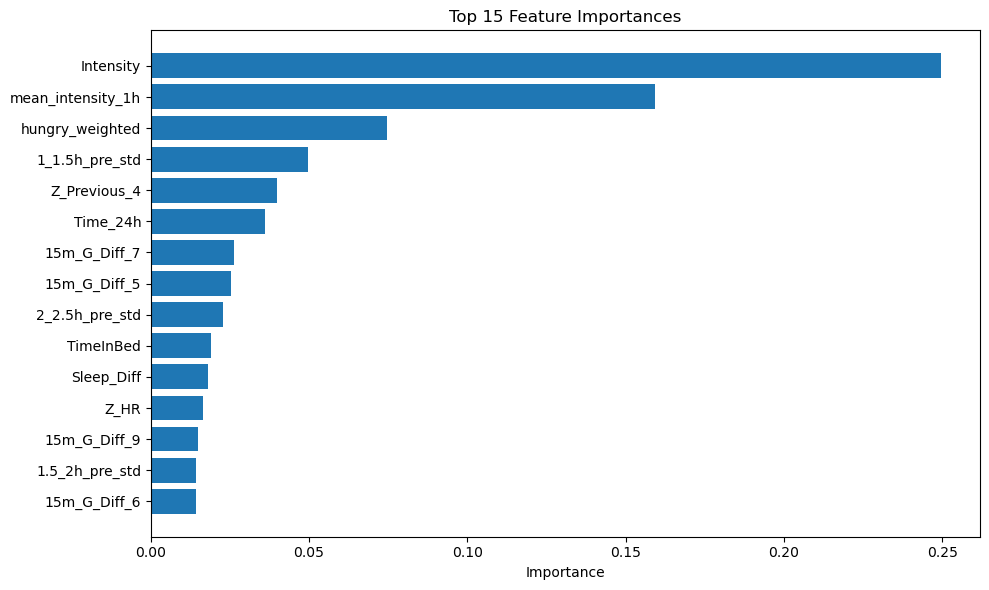

In [220]:
# RandomForestClassifier가 base_model로 래핑되어 있다고 가정
rf_model = best_model.base_model  # 또는 best_model.named_steps["base_model"]

importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n🔍 Feature Importance (Top 15):")
print(importances.head(15))

# 시각화 (선택 사항)
plt.figure(figsize=(10, 6))
plt.barh(importances.head(15)["Feature"][::-1], importances.head(15)["Importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()



# F1-Threshold

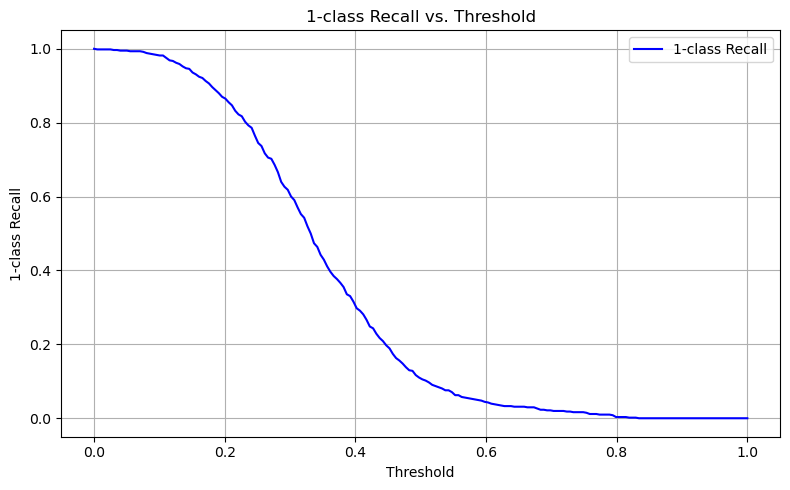

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# threshold sweep
thresholds = np.linspace(0, 1, 200)
recalls = [recall_score(y_test, (y_proba >= t).astype(int), zero_division=0) for t in thresholds]

# plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls, label="1-class Recall", color="blue")
plt.xlabel("Threshold")
plt.ylabel("1-class Recall")
plt.title("1-class Recall vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 최적 threshold (recall 최대)
best_idx = np.argmax(recalls)
best_threshold = thresholds[best_idx]
best_recall = recalls[best_idx]



🔍 Best Threshold for F1: 0.3216 (F1 Score = 0.3096)


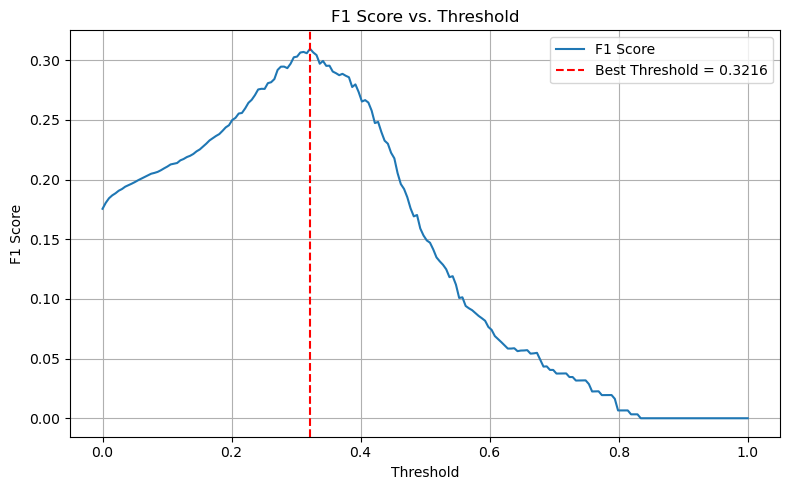

In [224]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# 다양한 threshold에서 f1 score 계산
thresholds = np.linspace(0, 1, 200)
f1_scores = [f1_score(y_test, (y_proba >= t).astype(int), zero_division=0) for t in thresholds]

# 최적 threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# 출력
print(f"🔍 Best Threshold for F1: {best_threshold:.4f} (F1 Score = {best_f1:.4f})")

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.axvline(best_threshold, color="r", linestyle="--", label=f"Best Threshold = {best_threshold:.4f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


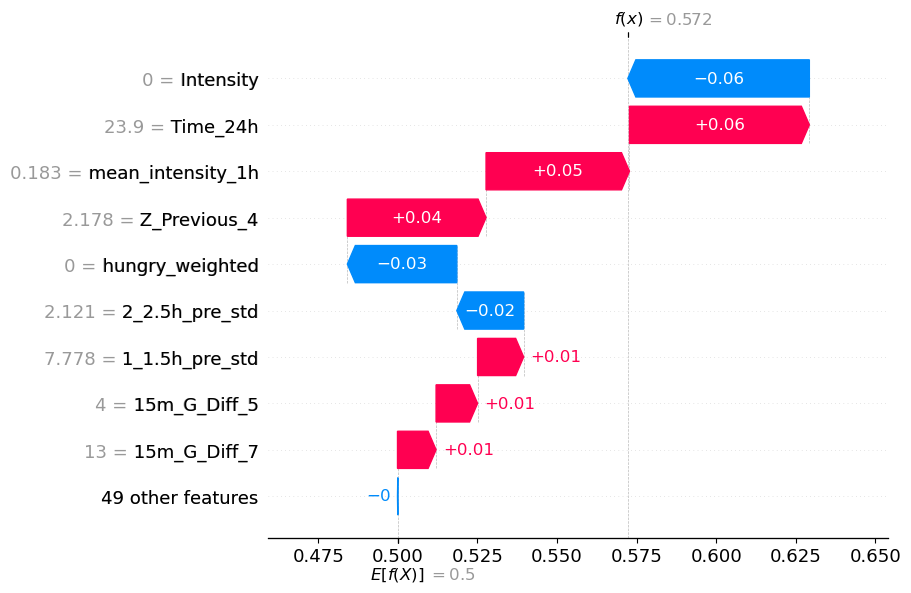

In [236]:
# SHAP explainer: base_model을 직접 전달
explainer = shap.TreeExplainer(best_model.base_model)  # best_model은 ThresholdClassifier

# 확률 0.5 넘는 인덱스 추출
high_prob_indices = np.where(y_proba > 0.5)[0]

if len(high_prob_indices) == 0:
    print("❌ No samples found with predicted probability > 0.5.")
else:
    idx = high_prob_indices[4]  # 다른 index로 바꿔도 됨
    x_row = X_test.iloc[[idx]]

    # SHAP 값 계산
    shap_values = explainer.shap_values(x_row)

    # Waterfall plot for class 1 (양성 클래스)
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][0],
            base_values=explainer.expected_value[1],
            data=x_row.values[0],
            feature_names=x_row.columns.tolist()
        )
    )



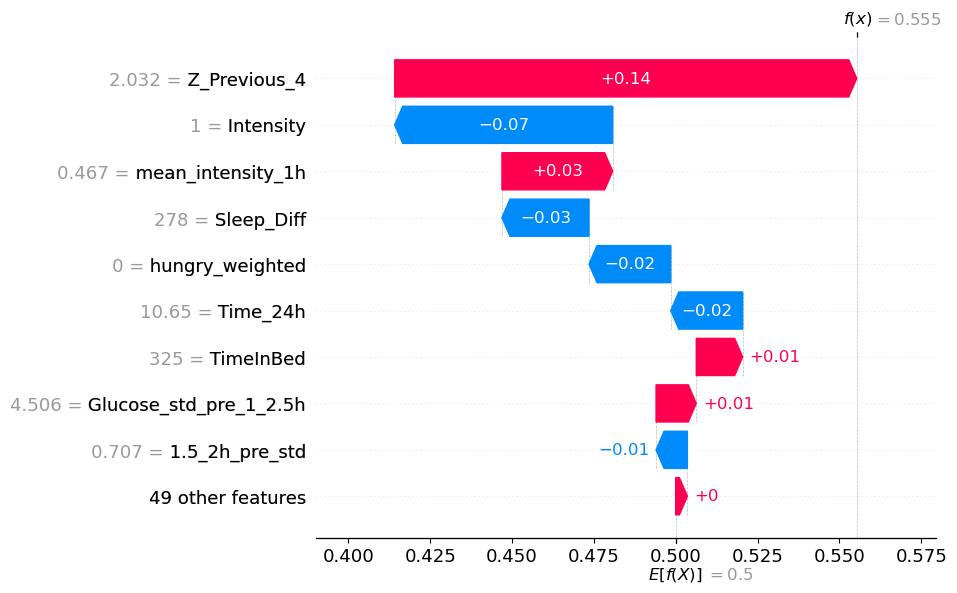

In [244]:
# SHAP explainer: base_model을 직접 전달
explainer = shap.TreeExplainer(best_model.base_model)  # best_model은 ThresholdClassifier

# 확률 0.5 넘는 인덱스 추출
high_prob_indices = np.where(y_proba > 0.5)[0]

if len(high_prob_indices) == 0:
    print("❌ No samples found with predicted probability > 0.5.")
else:
    idx = high_prob_indices[6]  # 다른 index로 바꿔도 됨
    x_row = X_test.iloc[[idx]]

    # SHAP 값 계산
    shap_values = explainer.shap_values(x_row)

    # Waterfall plot for class 1 (양성 클래스)
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][0],
            base_values=explainer.expected_value[1],
            data=x_row.values[0],
            feature_names=x_row.columns.tolist()
        )
    )


In [238]:
intensity_counts = df['Intensity'].value_counts(dropna=False).sort_index()
intensity_counts

Intensity
0.0    57347
1.0    12450
2.0      745
3.0      768
NaN      407
Name: count, dtype: int64

In [240]:
ge_event_rate = df.groupby('Intensity')['GE_1h'].mean()
print(ge_event_rate)


Intensity
0.0    0.083836
1.0    0.126066
2.0    0.166667
3.0    0.154589
Name: GE_1h, dtype: object



📊 GE event 비율 (시간대별)
Time_hour_bin
0     0.059207
1     0.028851
2     0.026688
3     0.027778
4     0.018559
5     0.017525
6     0.032009
7     0.059544
8     0.077138
9     0.080157
10    0.092697
11    0.085214
12    0.156409
13    0.156682
14    0.138498
15    0.131737
16     0.11779
17     0.14075
18    0.157632
19    0.154232
20    0.163831
21     0.13952
22    0.126502
23    0.088608
Name: GE_1h, dtype: object


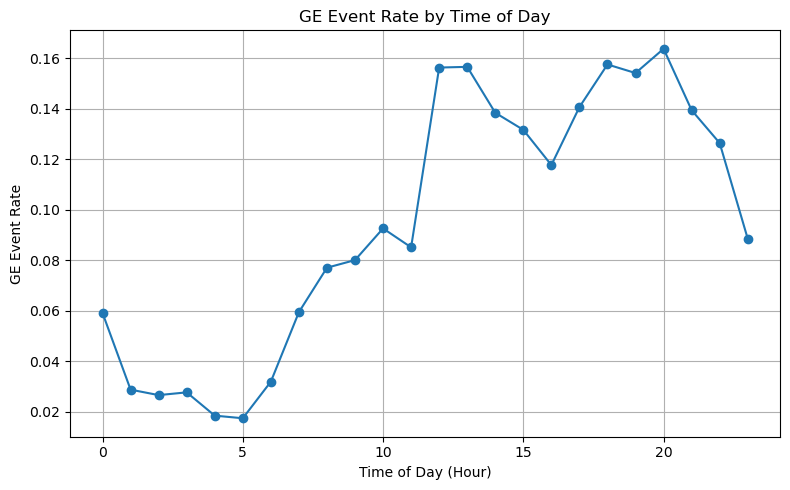

In [80]:
import pandas as pd

# Time_24h가 float 형태로 0~24 사이 값이라고 가정
# 1시간 단위로 bin 생성
df['Time_hour_bin'] = df['Time_24h'].apply(lambda x: int(x))

# 각 시간대 bin별 GE event 비율 계산
ge_rate_by_hour = df.groupby('Time_hour_bin')['GE_1h'].mean()

# 출력
print("\n📊 GE event 비율 (시간대별)")
print(ge_rate_by_hour)

# 시각화 (선택)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(ge_rate_by_hour.index, ge_rate_by_hour.values, marker='o')
plt.xlabel('Time of Day (Hour)')
plt.ylabel('GE Event Rate')
plt.title('GE Event Rate by Time of Day')
plt.grid(True)
plt.tight_layout()
plt.show()


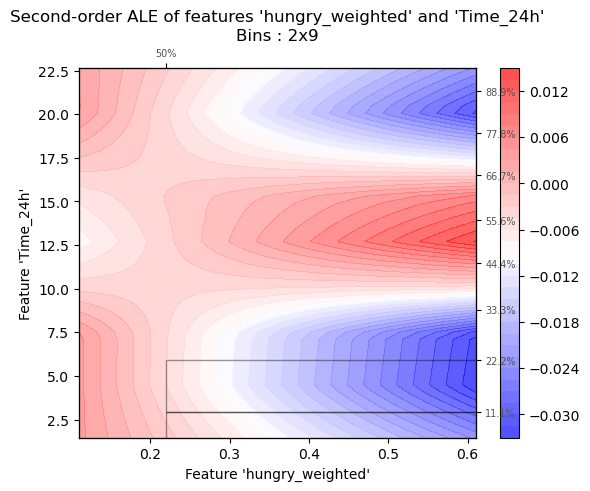

<Axes: title={'center': "Second-order ALE of features 'hungry_weighted' and 'Time_24h'\nBins : 2x9"}, xlabel="Feature 'hungry_weighted'", ylabel="Feature 'Time_24h'">

In [256]:
from alepython import ale_plot
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore", message="X has feature names, but RandomForestClassifier was fitted without feature names")

# DataFrame으로 변환
X_train_df = pd.DataFrame(X_train, columns=X.columns)


# ALE Plot 그리기 (제한된 데이터로)
ale_plot(
    model=best_model,
    train_set=X_train_df,
    features=[ "hungry_weighted","Time_24h"],
    monte_carlo_rep=1000,
    bins=9,
)


# Validation

In [260]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.metrics import classification_report

# ------------------- 1. Holdout 참가자 데이터 로드 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["GE_1h"])

# ------------------- 2. 예측 준비 -------------------
X_holdout = holdout_df[X_columns]
y_holdout = holdout_df["GE_1h"].astype(int)

# 예측
threshold = 0.3
y_holdout_proba = best_model.predict_proba(X_holdout)[:, 1]
y_holdout_pred = (y_holdout_proba >= threshold).astype(int)

# 예측 결과 저장
holdout_df["Predicted"] = y_holdout_pred
holdout_df["Predicted_Proba"] = y_holdout_proba

# ------------------- 3. Timestamp 파싱 -------------------
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])

# ------------------- 4. Early Warning 탐지 함수 -------------------
def detect_early_warning_with_cooldown(df, threshold=0.3, lead_minutes=60, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    ge_indices = df.index[df["GE_1h"] == 1].tolist()
    early_detected = 0
    last_alert_time = None

    for ge_idx in ge_indices:
        ge_time = df.loc[ge_idx, "Timestamp"]
        window_start = ge_time - timedelta(minutes=lead_minutes)
        prior_window = df[(df["Timestamp"] >= window_start) & (df["Timestamp"] < ge_time)]

        if not prior_window.empty:
            valid_alerts = prior_window[
                (prior_window["Predicted_Proba"] >= threshold) &
                (
                    last_alert_time is None or
                    (prior_window["Timestamp"] >= last_alert_time + timedelta(minutes=cooldown_minutes)).any()
                )
            ]
            if not valid_alerts.empty:
                early_detected += 1
                last_alert_time = valid_alerts["Timestamp"].min()

    return early_detected, len(ge_indices)

# ------------------- 5. 참가자별 평가 -------------------
results = []
for sid in holdout_df["StudyID"].unique():
    sub_df = holdout_df[holdout_df["StudyID"] == sid]
    detected, total = detect_early_warning_with_cooldown(
        sub_df, threshold=threshold, lead_minutes=60, cooldown_minutes=120
    )
    results.append({
        "StudyID": sid,
        "Detected_GE": detected,
        "Total_GE": total,
        "Detection_Rate": detected / total if total > 0 else np.nan
    })

# ------------------- 6. 요약 -------------------
result_df = pd.DataFrame(results)
print("📊 Early Warning Detection Results (60 min window + 2hr cooldown):")
print(result_df)

# ------------------- 7. 전체 통계 -------------------
overall_detected = result_df["Detected_GE"].sum()
overall_total = result_df["Total_GE"].sum()
overall_rate = overall_detected / overall_total if overall_total > 0 else np.nan

print(f"\n✅ Overall Detection Rate (with cooldown): {overall_detected}/{overall_total} = {overall_rate:.4f}")


📊 Early Warning Detection Results (60 min window + 2hr cooldown):
   StudyID  Detected_GE  Total_GE  Detection_Rate
0        8           15        60        0.250000
1       40           17        89        0.191011
2       59           12        50        0.240000
3       86           15        66        0.227273

✅ Overall Detection Rate (with cooldown): 59/265 = 0.2226


🗓 Participant 40 - Random GE Date: 2022-12-13


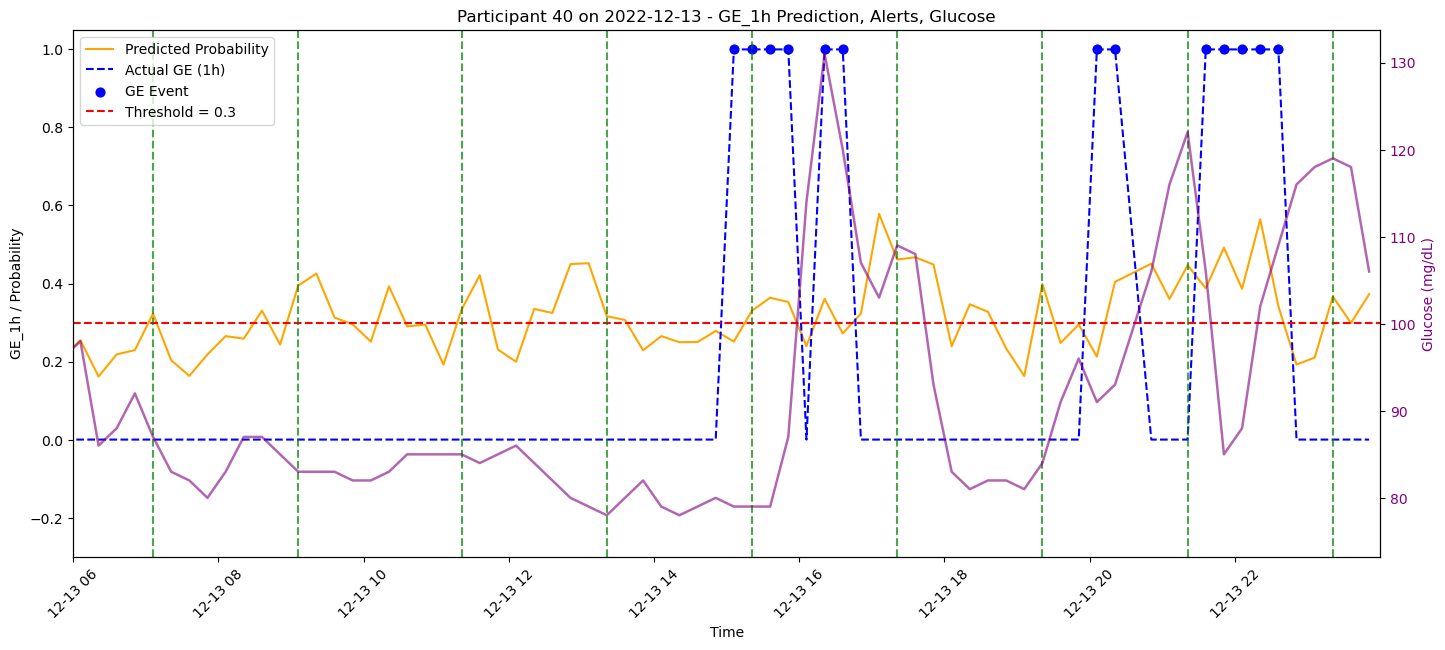

📋 Alert Summary:
           Alert_Time     TP  Success
0 2022-12-13 07:06:00  False    False
1 2022-12-13 09:06:00  False    False
2 2022-12-13 11:21:00  False    False
3 2022-12-13 13:21:00  False     True
4 2022-12-13 15:21:00   True     True
5 2022-12-13 17:21:00  False    False
6 2022-12-13 19:21:00   True     True
7 2022-12-13 21:21:00   True     True
8 2022-12-13 23:21:00  False    False

✅ Total Alerts: 9
🎯 TP (GE within 1hr): 3
🏆 Success (GE 1-2hr after alert): 4
❌ FP: 6


In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# 날짜 컬럼 생성
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# 랜덤 날짜 추출 함수
def get_random_ge_day(df, study_id):
    sub_df = df[df["StudyID"] == study_id]
    ge_dates = sub_df[sub_df["GE_1h"] == 1]["Date"].unique()
    if len(ge_dates) == 0:
        return None
    return np.random.choice(ge_dates)

# 알림 시점 계산 (쿨다운 포함, 06시~자정 사이만 허용)
def get_alert_times(df, threshold=0.3, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    alert_times = []
    last_alert_time = pd.Timestamp.min

    for _, row in df.iterrows():
        hour = row["Timestamp"].hour
        if (
            row["Predicted_Proba"] >= threshold
            and row["Timestamp"] >= last_alert_time + timedelta(minutes=cooldown_minutes)
            and 6 <= hour < 24
        ):
            alert_times.append(row["Timestamp"])
            last_alert_time = row["Timestamp"]
    return alert_times

# 시각화 및 결과 요약
def plot_single_day_alerts_with_stats(
    df, study_id, date, threshold=0.3, cooldown_minutes=120, lead_minutes=60
):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    ge_times = sub_df[sub_df["GE_1h"] == 1]["Timestamp"].tolist()

    results = []
    tp_count = 0
    fp_count = 0
    success_count = 0

    for alert_time in alert_times:
        # TP 정의: 0~60분 사이 GE 발생
        has_tp = any(alert_time <= ge_time <= alert_time + timedelta(minutes=lead_minutes) for ge_time in ge_times)
        if has_tp:
            tp_count += 1
        else:
            fp_count += 1

        # Success 정의: 0~120분 사이 GE 발생
        has_success = any(
    alert_time <= ge_time <= (alert_time + timedelta(minutes=120))
    for ge_time in ge_times
)
        results.append({
            "Alert_Time": alert_time,
            "TP": has_tp,
            "Success": has_success
        })
        if has_success:
            success_count += 1

    # 시각화
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.plot(sub_df["Timestamp"], sub_df["GE_1h"], label="Actual GE (1h)", linestyle="--", color="blue")
    ax1.scatter(sub_df[sub_df["GE_1h"] == 1]["Timestamp"], [1]*sum(sub_df["GE_1h"] == 1),
                color="blue", s=40, marker="o", label="GE Event")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)

    ax1.set_ylabel("GE_1h / Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    fig.tight_layout()
    plt.xticks(rotation=45)

    # Glucose plot
    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")

    plt.title(f"Participant {study_id} on {date} - GE_1h Prediction, Alerts, Glucose")
    plt.show()

    # 결과 요약 표
    result_df = pd.DataFrame(results)
    print("📋 Alert Summary:")
    print(result_df)
    print(f"\n✅ Total Alerts: {len(alert_times)}")
    print(f"🎯 TP (GE within 1hr): {tp_count}")
    print(f"🏆 Success (GE 1-2hr after alert): {success_count}")
    print(f"❌ FP: {fp_count}")

# ✅ 사용 예시
participant_id = 40  # 원하는 ID로 변경
random_date = get_random_ge_day(holdout_df, participant_id)

if random_date is not None:
    print(f"🗓 Participant {participant_id} - Random GE Date: {random_date}")
    plot_single_day_alerts_with_stats(
        df=holdout_df,
        study_id=participant_id,
        date=random_date,
        threshold=0.3,
        cooldown_minutes=120,
        lead_minutes=60
    )
else:
    print(f"❌ No GE date found for participant {participant_id}")


🗓 Participant 40 - Random GE Date: 2022-12-18


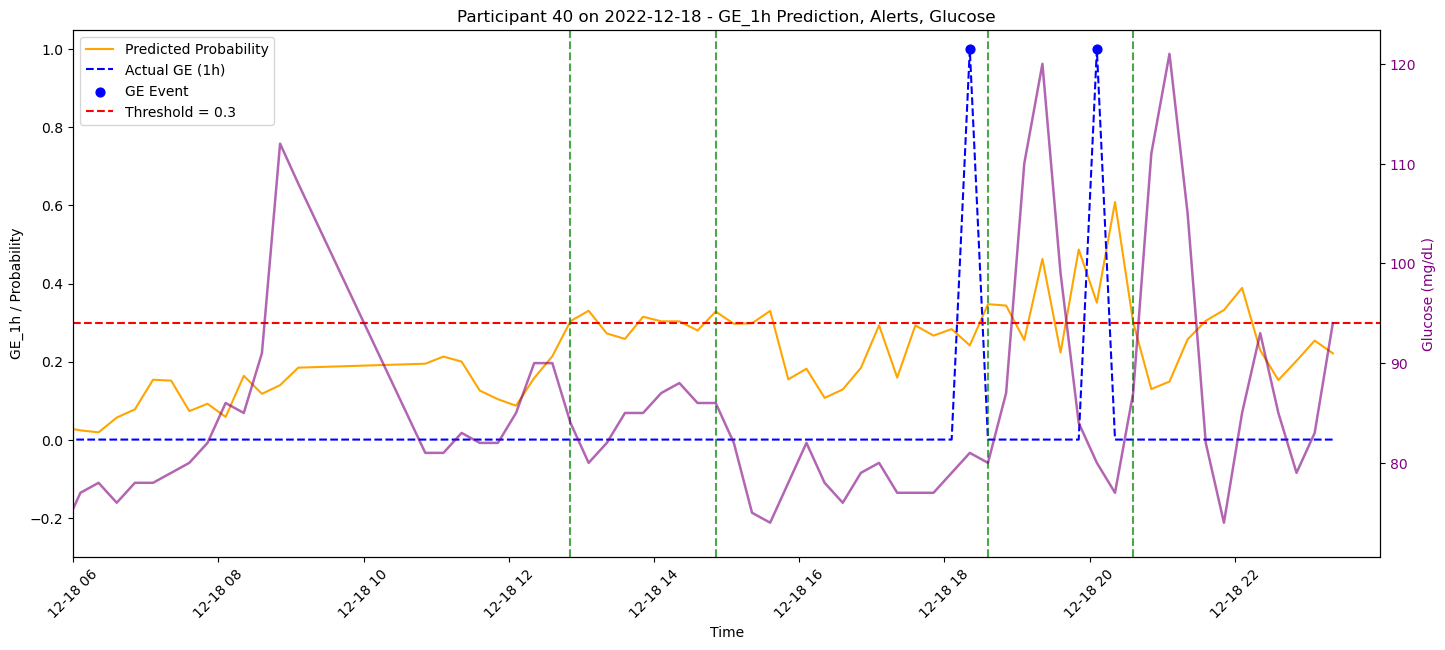

📋 Alert Summary:
           Alert_Time     TP  Success
0 2022-12-18 12:51:00  False    False
1 2022-12-18 14:51:00  False    False
2 2022-12-18 18:36:00  False     True
3 2022-12-18 20:36:00  False    False

✅ Total Alerts: 4
🎯 TP (GE within 1hr): 0
🏆 Success (GE 1-2hr after alert): 1
❌ FP: 4


In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# 날짜 컬럼 생성
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# 랜덤 날짜 추출 함수
def get_random_ge_day(df, study_id):
    sub_df = df[df["StudyID"] == study_id]
    ge_dates = sub_df[sub_df["GE_1h"] == 1]["Date"].unique()
    if len(ge_dates) == 0:
        return None
    return np.random.choice(ge_dates)

# 알림 시점 계산 (쿨다운 포함, 06시~자정 사이만 허용)
def get_alert_times(df, threshold=0.3, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    alert_times = []
    last_alert_time = pd.Timestamp.min

    for _, row in df.iterrows():
        hour = row["Timestamp"].hour
        if (
            row["Predicted_Proba"] >= threshold
            and row["Timestamp"] >= last_alert_time + timedelta(minutes=cooldown_minutes)
            and 6 <= hour < 24
        ):
            alert_times.append(row["Timestamp"])
            last_alert_time = row["Timestamp"]
    return alert_times

# 시각화 및 결과 요약
def plot_single_day_alerts_with_stats(
    df, study_id, date, threshold=0.3, cooldown_minutes=120, lead_minutes=60
):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    ge_times = sub_df[sub_df["GE_1h"] == 1]["Timestamp"].tolist()

    results = []
    tp_count = 0
    fp_count = 0
    success_count = 0

    for alert_time in alert_times:
        # TP 정의: 0~60분 사이 GE 발생
        has_tp = any(alert_time <= ge_time <= alert_time + timedelta(minutes=lead_minutes) for ge_time in ge_times)
        if has_tp:
            tp_count += 1
        else:
            fp_count += 1

        # Success 정의: 0~120분 사이 GE 발생
        has_success = any(
    alert_time <= ge_time <= (alert_time + timedelta(minutes=120))
    for ge_time in ge_times
)
        results.append({
            "Alert_Time": alert_time,
            "TP": has_tp,
            "Success": has_success
        })
        if has_success:
            success_count += 1

    # 시각화
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.plot(sub_df["Timestamp"], sub_df["GE_1h"], label="Actual GE (1h)", linestyle="--", color="blue")
    ax1.scatter(sub_df[sub_df["GE_1h"] == 1]["Timestamp"], [1]*sum(sub_df["GE_1h"] == 1),
                color="blue", s=40, marker="o", label="GE Event")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)

    ax1.set_ylabel("GE_1h / Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    fig.tight_layout()
    plt.xticks(rotation=45)

    # Glucose plot
    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")

    plt.title(f"Participant {study_id} on {date} - GE_1h Prediction, Alerts, Glucose")
    plt.show()

    # 결과 요약 표
    result_df = pd.DataFrame(results)
    print("📋 Alert Summary:")
    print(result_df)
    print(f"\n✅ Total Alerts: {len(alert_times)}")
    print(f"🎯 TP (GE within 1hr): {tp_count}")
    print(f"🏆 Success (GE 1-2hr after alert): {success_count}")
    print(f"❌ FP: {fp_count}")

# ✅ 사용 예시
participant_id = 40  # 원하는 ID로 변경
random_date = get_random_ge_day(holdout_df, participant_id)

if random_date is not None:
    print(f"🗓 Participant {participant_id} - Random GE Date: {random_date}")
    plot_single_day_alerts_with_stats(
        df=holdout_df,
        study_id=participant_id,
        date=random_date,
        threshold=0.3,
        cooldown_minutes=120,
        lead_minutes=60
    )
else:
    print(f"❌ No GE date found for participant {participant_id}")

🗓 Participant 59 - Random GE Date: 2023-03-14


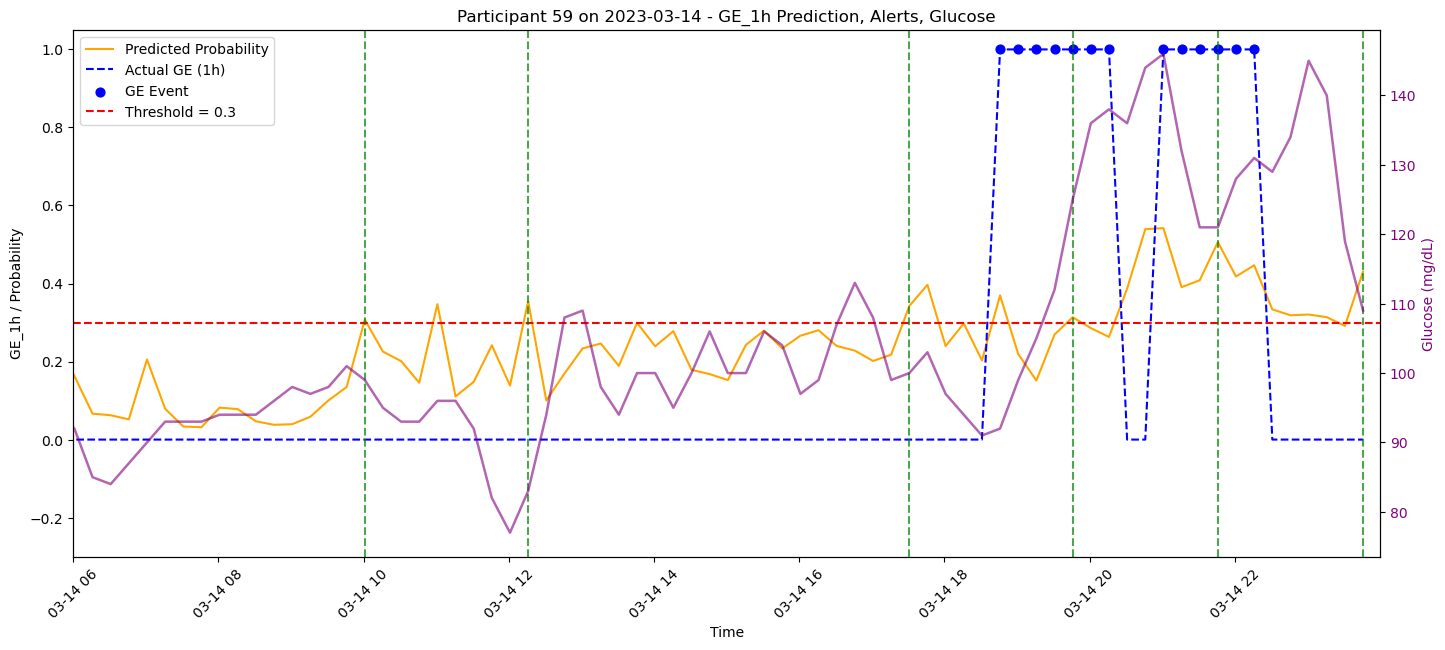

📋 Alert Summary:
           Alert_Time     TP  Success
0 2023-03-14 10:01:00  False    False
1 2023-03-14 12:16:00  False    False
2 2023-03-14 17:31:00  False     True
3 2023-03-14 19:46:00   True     True
4 2023-03-14 21:46:00   True     True
5 2023-03-14 23:46:00  False    False

✅ Total Alerts: 6
🎯 TP (GE within 1hr): 2
🏆 Success (GE 1-2hr after alert): 3
❌ FP: 4


In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# 날짜 컬럼 생성
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# 랜덤 날짜 추출 함수
def get_random_ge_day(df, study_id):
    sub_df = df[df["StudyID"] == study_id]
    ge_dates = sub_df[sub_df["GE_1h"] == 1]["Date"].unique()
    if len(ge_dates) == 0:
        return None
    return np.random.choice(ge_dates)

# 알림 시점 계산 (쿨다운 포함, 06시~자정 사이만 허용)
def get_alert_times(df, threshold=0.3, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    alert_times = []
    last_alert_time = pd.Timestamp.min

    for _, row in df.iterrows():
        hour = row["Timestamp"].hour
        if (
            row["Predicted_Proba"] >= threshold
            and row["Timestamp"] >= last_alert_time + timedelta(minutes=cooldown_minutes)
            and 6 <= hour < 24
        ):
            alert_times.append(row["Timestamp"])
            last_alert_time = row["Timestamp"]
    return alert_times

# 시각화 및 결과 요약
def plot_single_day_alerts_with_stats(
    df, study_id, date, threshold=0.3, cooldown_minutes=120, lead_minutes=60
):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    ge_times = sub_df[sub_df["GE_1h"] == 1]["Timestamp"].tolist()

    results = []
    tp_count = 0
    fp_count = 0
    success_count = 0

    for alert_time in alert_times:
        # TP 정의: 0~60분 사이 GE 발생
        has_tp = any(alert_time <= ge_time <= alert_time + timedelta(minutes=lead_minutes) for ge_time in ge_times)
        if has_tp:
            tp_count += 1
        else:
            fp_count += 1

        # Success 정의: 0~120분 사이 GE 발생
        has_success = any(
    alert_time <= ge_time <= (alert_time + timedelta(minutes=120))
    for ge_time in ge_times
)
        results.append({
            "Alert_Time": alert_time,
            "TP": has_tp,
            "Success": has_success
        })
        if has_success:
            success_count += 1

    # 시각화
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.plot(sub_df["Timestamp"], sub_df["GE_1h"], label="Actual GE (1h)", linestyle="--", color="blue")
    ax1.scatter(sub_df[sub_df["GE_1h"] == 1]["Timestamp"], [1]*sum(sub_df["GE_1h"] == 1),
                color="blue", s=40, marker="o", label="GE Event")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)

    ax1.set_ylabel("GE_1h / Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    fig.tight_layout()
    plt.xticks(rotation=45)

    # Glucose plot
    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")

    plt.title(f"Participant {study_id} on {date} - GE_1h Prediction, Alerts, Glucose")
    plt.show()

    # 결과 요약 표
    result_df = pd.DataFrame(results)
    print("📋 Alert Summary:")
    print(result_df)
    print(f"\n✅ Total Alerts: {len(alert_times)}")
    print(f"🎯 TP (GE within 1hr): {tp_count}")
    print(f"🏆 Success (GE 1-2hr after alert): {success_count}")
    print(f"❌ FP: {fp_count}")

# ✅ 사용 예시
participant_id = 59  # 원하는 ID로 변경
random_date = get_random_ge_day(holdout_df, participant_id)

if random_date is not None:
    print(f"🗓 Participant {participant_id} - Random GE Date: {random_date}")
    plot_single_day_alerts_with_stats(
        df=holdout_df,
        study_id=participant_id,
        date=random_date,
        threshold=0.3,
        cooldown_minutes=120,
        lead_minutes=60
    )
else:
    print(f"❌ No GE date found for participant {participant_id}")

🗓 Participant 59 - Random GE Date: 2023-03-19


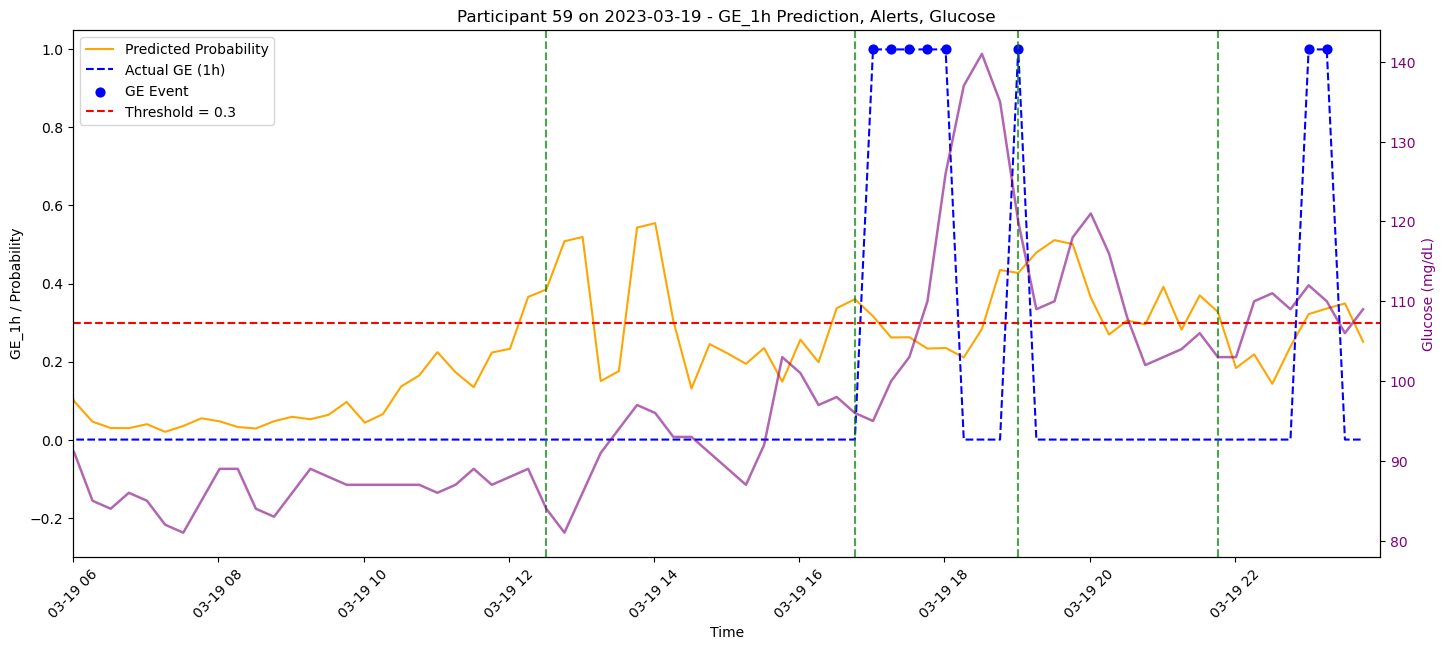

📋 Alert Summary:
           Alert_Time     TP  Success
0 2023-03-19 12:31:00  False    False
1 2023-03-19 16:46:00   True     True
2 2023-03-19 19:01:00   True     True
3 2023-03-19 21:46:00  False     True

✅ Total Alerts: 4
🎯 TP (GE within 1hr): 2
🏆 Success (GE 1-2hr after alert): 3
❌ FP: 2


In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# 날짜 컬럼 생성
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# 랜덤 날짜 추출 함수
def get_random_ge_day(df, study_id):
    sub_df = df[df["StudyID"] == study_id]
    ge_dates = sub_df[sub_df["GE_1h"] == 1]["Date"].unique()
    if len(ge_dates) == 0:
        return None
    return np.random.choice(ge_dates)

# 알림 시점 계산 (연속 조건 + 쿨다운 + 06시~자정)
def get_alert_times(df, threshold=0.3, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        row = df.iloc[i]
        hour = row["Timestamp"].hour
        if (
            df.loc[i, "Rolling_Sum"] >= 2 and
            row["Timestamp"] >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            6 <= hour < 24
        ):
            alert_times.append(row["Timestamp"])
            last_alert_time = row["Timestamp"]
    return alert_times

# 시각화 및 결과 요약
def plot_single_day_alerts_with_stats(
    df, study_id, date, threshold=0.3, cooldown_minutes=120, lead_minutes=60
):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    ge_times = sub_df[sub_df["GE_1h"] == 1]["Timestamp"].tolist()

    results = []
    tp_count = 0
    fp_count = 0
    success_count = 0

    for alert_time in alert_times:
        has_tp = any(alert_time <= ge_time <= alert_time + timedelta(minutes=lead_minutes) for ge_time in ge_times)
        if has_tp:
            tp_count += 1
        else:
            fp_count += 1

        has_success = any(
            alert_time <= ge_time <= (alert_time + timedelta(minutes=120)) for ge_time in ge_times
        )
        results.append({
            "Alert_Time": alert_time,
            "TP": has_tp,
            "Success": has_success
        })
        if has_success:
            success_count += 1

    # 시각화
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.plot(sub_df["Timestamp"], sub_df["GE_1h"], label="Actual GE (1h)", linestyle="--", color="blue")
    ax1.scatter(sub_df[sub_df["GE_1h"] == 1]["Timestamp"], [1]*sum(sub_df["GE_1h"] == 1),
                color="blue", s=40, marker="o", label="GE Event")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)

    ax1.set_ylabel("GE_1h / Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    fig.tight_layout()
    plt.xticks(rotation=45)

    # Glucose plot
    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")

    plt.title(f"Participant {study_id} on {date} - GE_1h Prediction, Alerts, Glucose")
    plt.show()

    # 결과 요약 표
    result_df = pd.DataFrame(results)
    print("📋 Alert Summary:")
    print(result_df)
    print(f"\n✅ Total Alerts: {len(alert_times)}")
    print(f"🎯 TP (GE within 1hr): {tp_count}")
    print(f"🏆 Success (GE 1-2hr after alert): {success_count}")
    print(f"❌ FP: {fp_count}")

# ✅ 사용 예시
participant_id = 59  # 원하는 ID로 변경
random_date = get_random_ge_day(holdout_df, participant_id)

if random_date is not None:
    print(f"🗓 Participant {participant_id} - Random GE Date: {random_date}")
    plot_single_day_alerts_with_stats(
        df=holdout_df,
        study_id=participant_id,
        date=random_date,
        threshold=0.3,
        cooldown_minutes=120,
        lead_minutes=60
    )
else:
    print(f"❌ No GE date found for participant {participant_id}")


🗓 Participant 59 - Random GE Date: 2023-03-14


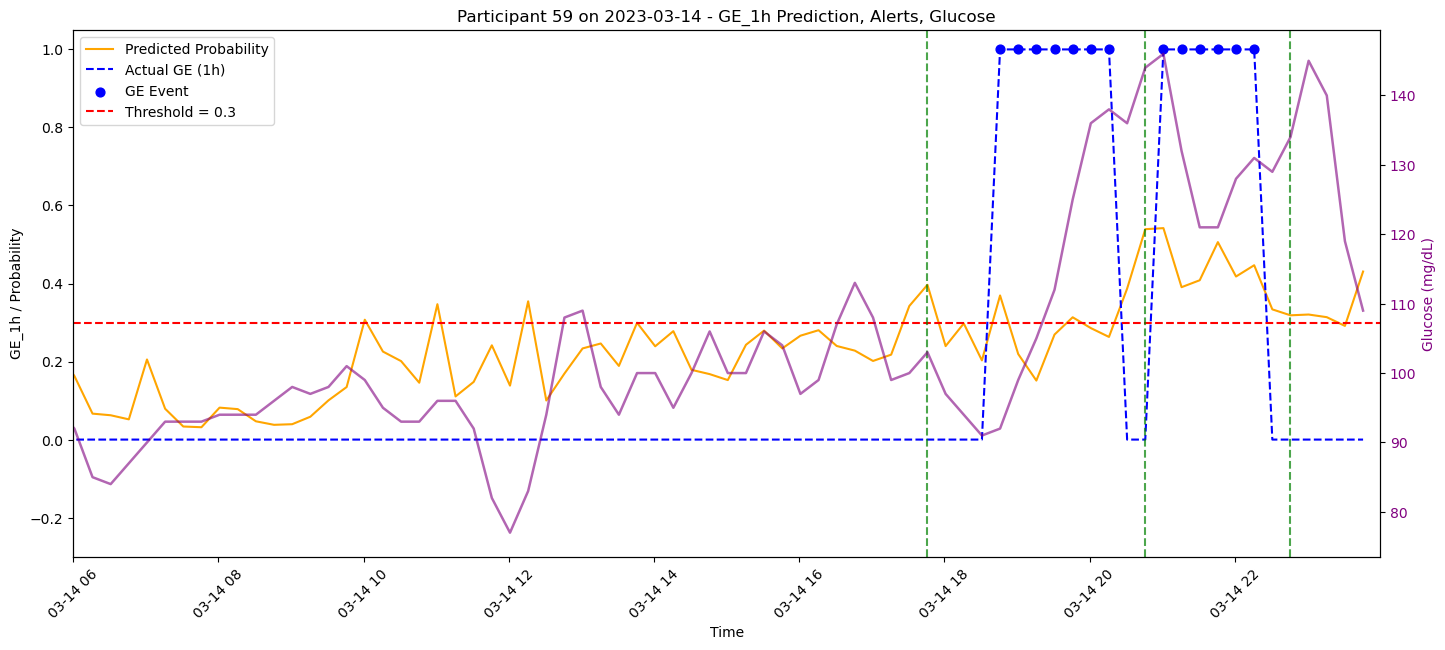

📋 Alert Summary:
           Alert_Time     TP  Success
0 2023-03-14 17:46:00   True     True
1 2023-03-14 20:46:00   True     True
2 2023-03-14 22:46:00  False    False

✅ Total Alerts: 3
🎯 TP (GE within 1hr): 2
🏆 Success (GE 1-2hr after alert): 2
❌ FP: 1


In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# 날짜 컬럼 생성
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# 랜덤 날짜 추출 함수
def get_random_ge_day(df, study_id):
    sub_df = df[df["StudyID"] == study_id]
    ge_dates = sub_df[sub_df["GE_1h"] == 1]["Date"].unique()
    if len(ge_dates) == 0:
        return None
    return np.random.choice(ge_dates)

# 알림 시점 계산 (연속 조건 + 쿨다운 + 06시~자정)
def get_alert_times(df, threshold=0.3, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        row = df.iloc[i]
        hour = row["Timestamp"].hour
        if (
            df.loc[i, "Rolling_Sum"] >= 2 and
            row["Timestamp"] >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            6 <= hour < 24
        ):
            alert_times.append(row["Timestamp"])
            last_alert_time = row["Timestamp"]
    return alert_times

# 시각화 및 결과 요약
def plot_single_day_alerts_with_stats(
    df, study_id, date, threshold=0.3, cooldown_minutes=120, lead_minutes=60
):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    ge_times = sub_df[sub_df["GE_1h"] == 1]["Timestamp"].tolist()

    results = []
    tp_count = 0
    fp_count = 0
    success_count = 0

    for alert_time in alert_times:
        has_tp = any(alert_time <= ge_time <= alert_time + timedelta(minutes=lead_minutes) for ge_time in ge_times)
        if has_tp:
            tp_count += 1
        else:
            fp_count += 1

        has_success = any(
            alert_time <= ge_time <= (alert_time + timedelta(minutes=120)) for ge_time in ge_times
        )
        results.append({
            "Alert_Time": alert_time,
            "TP": has_tp,
            "Success": has_success
        })
        if has_success:
            success_count += 1

    # 시각화
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.plot(sub_df["Timestamp"], sub_df["GE_1h"], label="Actual GE (1h)", linestyle="--", color="blue")
    ax1.scatter(sub_df[sub_df["GE_1h"] == 1]["Timestamp"], [1]*sum(sub_df["GE_1h"] == 1),
                color="blue", s=40, marker="o", label="GE Event")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)

    ax1.set_ylabel("GE_1h / Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    fig.tight_layout()
    plt.xticks(rotation=45)

    # Glucose plot
    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")

    plt.title(f"Participant {study_id} on {date} - GE_1h Prediction, Alerts, Glucose")
    plt.show()

    # 결과 요약 표
    result_df = pd.DataFrame(results)
    print("📋 Alert Summary:")
    print(result_df)
    print(f"\n✅ Total Alerts: {len(alert_times)}")
    print(f"🎯 TP (GE within 1hr): {tp_count}")
    print(f"🏆 Success (GE 1-2hr after alert): {success_count}")
    print(f"❌ FP: {fp_count}")

# ✅ 사용 예시
participant_id = 59  # 원하는 ID로 변경
random_date = get_random_ge_day(holdout_df, participant_id)

if random_date is not None:
    print(f"🗓 Participant {participant_id} - Random GE Date: {random_date}")
    plot_single_day_alerts_with_stats(
        df=holdout_df,
        study_id=participant_id,
        date=random_date,
        threshold=0.3,
        cooldown_minutes=120,
        lead_minutes=60
    )
else:
    print(f"❌ No GE date found for participant {participant_id}")


🗓 Participant 59 - Random GE Date: 2023-03-20


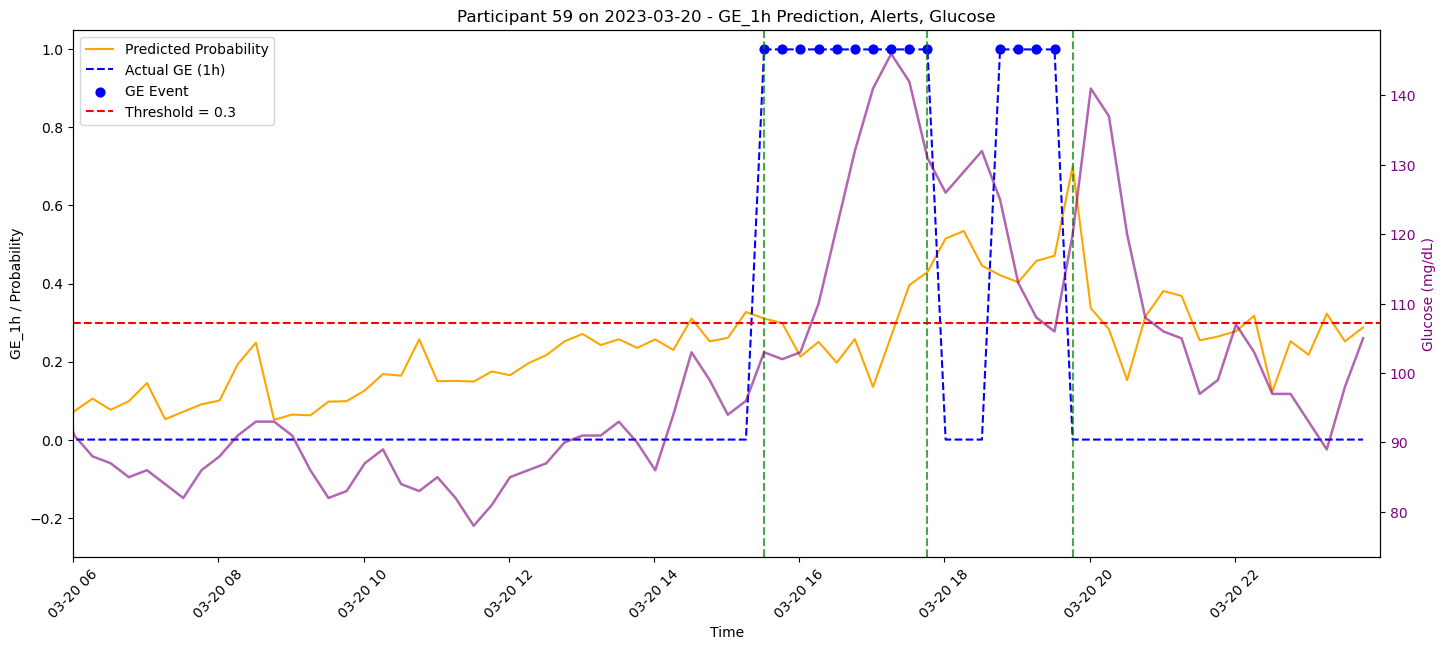

📋 Alert Summary:
           Alert_Time     TP  Success
0 2023-03-20 15:31:00   True     True
1 2023-03-20 17:46:00   True     True
2 2023-03-20 19:46:00  False    False

✅ Total Alerts: 3
🎯 TP (GE within 1hr): 2
🏆 Success (GE 1-2hr after alert): 2
❌ FP: 1


In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# 날짜 컬럼 생성
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# 랜덤 날짜 추출 함수
def get_random_ge_day(df, study_id):
    sub_df = df[df["StudyID"] == study_id]
    ge_dates = sub_df[sub_df["GE_1h"] == 1]["Date"].unique()
    if len(ge_dates) == 0:
        return None
    return np.random.choice(ge_dates)

# 알림 시점 계산 (연속 조건 + 쿨다운 + 06시~자정)
def get_alert_times(df, threshold=0.3, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        row = df.iloc[i]
        hour = row["Timestamp"].hour
        if (
            df.loc[i, "Rolling_Sum"] >= 2 and
            row["Timestamp"] >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            6 <= hour < 24
        ):
            alert_times.append(row["Timestamp"])
            last_alert_time = row["Timestamp"]
    return alert_times

# 시각화 및 결과 요약
def plot_single_day_alerts_with_stats(
    df, study_id, date, threshold=0.3, cooldown_minutes=120, lead_minutes=60
):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    ge_times = sub_df[sub_df["GE_1h"] == 1]["Timestamp"].tolist()

    results = []
    tp_count = 0
    fp_count = 0
    success_count = 0

    for alert_time in alert_times:
        has_tp = any(alert_time <= ge_time <= alert_time + timedelta(minutes=lead_minutes) for ge_time in ge_times)
        if has_tp:
            tp_count += 1
        else:
            fp_count += 1

        has_success = any(
            alert_time <= ge_time <= (alert_time + timedelta(minutes=120)) for ge_time in ge_times
        )
        results.append({
            "Alert_Time": alert_time,
            "TP": has_tp,
            "Success": has_success
        })
        if has_success:
            success_count += 1

    # 시각화
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.plot(sub_df["Timestamp"], sub_df["GE_1h"], label="Actual GE (1h)", linestyle="--", color="blue")
    ax1.scatter(sub_df[sub_df["GE_1h"] == 1]["Timestamp"], [1]*sum(sub_df["GE_1h"] == 1),
                color="blue", s=40, marker="o", label="GE Event")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)

    ax1.set_ylabel("GE_1h / Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    fig.tight_layout()
    plt.xticks(rotation=45)

    # Glucose plot
    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")

    plt.title(f"Participant {study_id} on {date} - GE_1h Prediction, Alerts, Glucose")
    plt.show()

    # 결과 요약 표
    result_df = pd.DataFrame(results)
    print("📋 Alert Summary:")
    print(result_df)
    print(f"\n✅ Total Alerts: {len(alert_times)}")
    print(f"🎯 TP (GE within 1hr): {tp_count}")
    print(f"🏆 Success (GE 1-2hr after alert): {success_count}")
    print(f"❌ FP: {fp_count}")

# ✅ 사용 예시
participant_id = 59  # 원하는 ID로 변경
random_date = get_random_ge_day(holdout_df, participant_id)

if random_date is not None:
    print(f"🗓 Participant {participant_id} - Random GE Date: {random_date}")
    plot_single_day_alerts_with_stats(
        df=holdout_df,
        study_id=participant_id,
        date=random_date,
        threshold=0.3,
        cooldown_minutes=120,
        lead_minutes=60
    )
else:
    print(f"❌ No GE date found for participant {participant_id}")


🗓 Participant 40 - Random GE Date: 2022-12-14


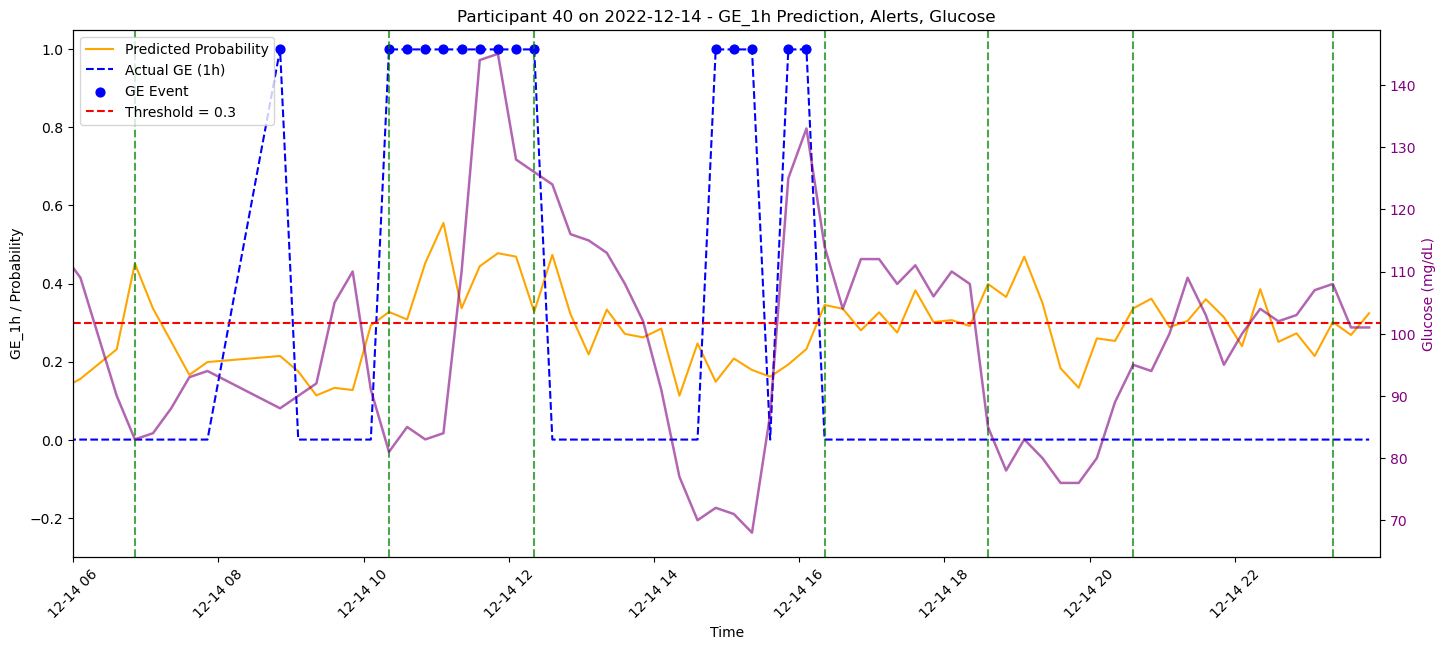

📋 Alert Summary:
           Alert_Time     TP  Success
0 2022-12-14 06:51:00  False     True
1 2022-12-14 10:21:00   True     True
2 2022-12-14 12:21:00   True     True
3 2022-12-14 16:21:00  False    False
4 2022-12-14 18:36:00  False    False
5 2022-12-14 20:36:00  False    False
6 2022-12-14 23:21:00  False    False

✅ Total Alerts: 7
🎯 TP (GE within 1hr): 2
🏆 Success (GE 1-2hr after alert): 3
❌ FP: 5


In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# 날짜 컬럼 생성
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# 랜덤 날짜 추출 함수
def get_random_ge_day(df, study_id):
    sub_df = df[df["StudyID"] == study_id]
    ge_dates = sub_df[sub_df["GE_1h"] == 1]["Date"].unique()
    if len(ge_dates) == 0:
        return None
    return np.random.choice(ge_dates)

# 알림 시점 계산 (쿨다운 포함, 06시~자정 사이만 허용)
def get_alert_times(df, threshold=0.3, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    alert_times = []
    last_alert_time = pd.Timestamp.min

    for _, row in df.iterrows():
        hour = row["Timestamp"].hour
        if (
            row["Predicted_Proba"] >= threshold
            and row["Timestamp"] >= last_alert_time + timedelta(minutes=cooldown_minutes)
            and 6 <= hour < 24
        ):
            alert_times.append(row["Timestamp"])
            last_alert_time = row["Timestamp"]
    return alert_times

# 시각화 및 결과 요약
def plot_single_day_alerts_with_stats(
    df, study_id, date, threshold=0.3, cooldown_minutes=120, lead_minutes=60
):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    ge_times = sub_df[sub_df["GE_1h"] == 1]["Timestamp"].tolist()

    results = []
    tp_count = 0
    fp_count = 0
    success_count = 0

    for alert_time in alert_times:
        # TP 정의: 0~60분 사이 GE 발생
        has_tp = any(alert_time <= ge_time <= alert_time + timedelta(minutes=lead_minutes) for ge_time in ge_times)
        if has_tp:
            tp_count += 1
        else:
            fp_count += 1

        # Success 정의: 0~120분 사이 GE 발생
        has_success = any(
    alert_time <= ge_time <= (alert_time + timedelta(minutes=120))
    for ge_time in ge_times
)
        results.append({
            "Alert_Time": alert_time,
            "TP": has_tp,
            "Success": has_success
        })
        if has_success:
            success_count += 1

    # 시각화
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.plot(sub_df["Timestamp"], sub_df["GE_1h"], label="Actual GE (1h)", linestyle="--", color="blue")
    ax1.scatter(sub_df[sub_df["GE_1h"] == 1]["Timestamp"], [1]*sum(sub_df["GE_1h"] == 1),
                color="blue", s=40, marker="o", label="GE Event")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)

    ax1.set_ylabel("GE_1h / Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    fig.tight_layout()
    plt.xticks(rotation=45)

    # Glucose plot
    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")

    plt.title(f"Participant {study_id} on {date} - GE_1h Prediction, Alerts, Glucose")
    plt.show()

    # 결과 요약 표
    result_df = pd.DataFrame(results)
    print("📋 Alert Summary:")
    print(result_df)
    print(f"\n✅ Total Alerts: {len(alert_times)}")
    print(f"🎯 TP (GE within 1hr): {tp_count}")
    print(f"🏆 Success (GE 1-2hr after alert): {success_count}")
    print(f"❌ FP: {fp_count}")

# ✅ 사용 예시
participant_id = 40  # 원하는 ID로 변경
random_date = get_random_ge_day(holdout_df, participant_id)

if random_date is not None:
    print(f"🗓 Participant {participant_id} - Random GE Date: {random_date}")
    plot_single_day_alerts_with_stats(
        df=holdout_df,
        study_id=participant_id,
        date=random_date,
        threshold=0.3,
        cooldown_minutes=120,
        lead_minutes=60
    )
else:
    print(f"❌ No GE date found for participant {participant_id}")

🗓 Participant 40 - Random GE Date: 2022-12-14


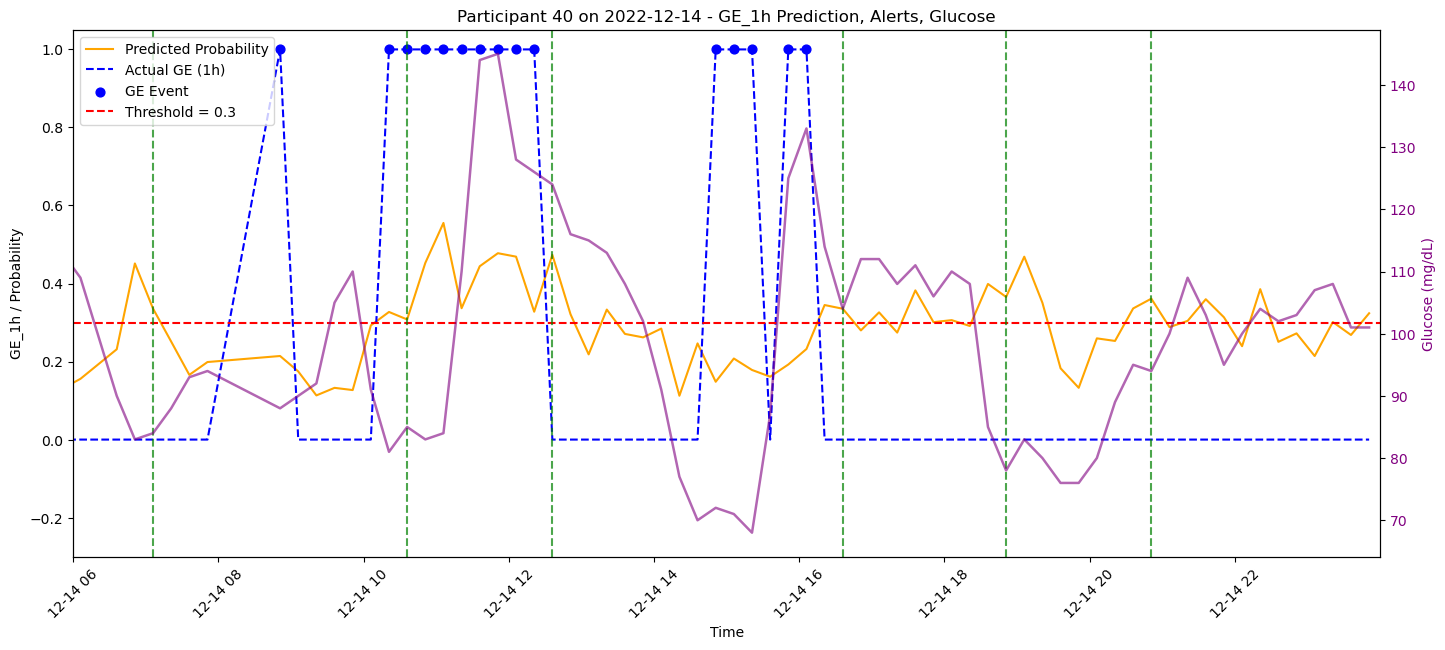

📋 Alert Summary:
           Alert_Time     TP  Success
0 2022-12-14 07:06:00  False     True
1 2022-12-14 10:36:00   True     True
2 2022-12-14 12:36:00  False    False
3 2022-12-14 16:36:00  False    False
4 2022-12-14 18:51:00  False    False
5 2022-12-14 20:51:00  False    False

✅ Total Alerts: 6
🎯 TP (GE within 1hr): 1
🏆 Success (GE 1-2hr after alert): 2
❌ FP: 5


In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# 날짜 컬럼 생성
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# 랜덤 날짜 추출 함수
def get_random_ge_day(df, study_id):
    sub_df = df[df["StudyID"] == study_id]
    ge_dates = sub_df[sub_df["GE_1h"] == 1]["Date"].unique()
    if len(ge_dates) == 0:
        return None
    return np.random.choice(ge_dates)

# 알림 시점 계산 (연속 조건 + 쿨다운 + 06시~자정)
def get_alert_times(df, threshold=0.3, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        row = df.iloc[i]
        hour = row["Timestamp"].hour
        if (
            df.loc[i, "Rolling_Sum"] >= 2 and
            row["Timestamp"] >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            6 <= hour < 24
        ):
            alert_times.append(row["Timestamp"])
            last_alert_time = row["Timestamp"]
    return alert_times

# 시각화 및 결과 요약
def plot_single_day_alerts_with_stats(
    df, study_id, date, threshold=0.3, cooldown_minutes=120, lead_minutes=60
):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    ge_times = sub_df[sub_df["GE_1h"] == 1]["Timestamp"].tolist()

    results = []
    tp_count = 0
    fp_count = 0
    success_count = 0

    for alert_time in alert_times:
        has_tp = any(alert_time <= ge_time <= alert_time + timedelta(minutes=lead_minutes) for ge_time in ge_times)
        if has_tp:
            tp_count += 1
        else:
            fp_count += 1

        has_success = any(
            alert_time <= ge_time <= (alert_time + timedelta(minutes=120)) for ge_time in ge_times
        )
        results.append({
            "Alert_Time": alert_time,
            "TP": has_tp,
            "Success": has_success
        })
        if has_success:
            success_count += 1

    # 시각화
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.plot(sub_df["Timestamp"], sub_df["GE_1h"], label="Actual GE (1h)", linestyle="--", color="blue")
    ax1.scatter(sub_df[sub_df["GE_1h"] == 1]["Timestamp"], [1]*sum(sub_df["GE_1h"] == 1),
                color="blue", s=40, marker="o", label="GE Event")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)

    ax1.set_ylabel("GE_1h / Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    fig.tight_layout()
    plt.xticks(rotation=45)

    # Glucose plot
    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")

    plt.title(f"Participant {study_id} on {date} - GE_1h Prediction, Alerts, Glucose")
    plt.show()

    # 결과 요약 표
    result_df = pd.DataFrame(results)
    print("📋 Alert Summary:")
    print(result_df)
    print(f"\n✅ Total Alerts: {len(alert_times)}")
    print(f"🎯 TP (GE within 1hr): {tp_count}")
    print(f"🏆 Success (GE 1-2hr after alert): {success_count}")
    print(f"❌ FP: {fp_count}")

# ✅ 사용 예시
participant_id = 40  # 원하는 ID로 변경
random_date = get_random_ge_day(holdout_df, participant_id)

if random_date is not None:
    print(f"🗓 Participant {participant_id} - Random GE Date: {random_date}")
    plot_single_day_alerts_with_stats(
        df=holdout_df,
        study_id=participant_id,
        date=random_date,
        threshold=0.3,
        cooldown_minutes=120,
        lead_minutes=60
    )
else:
    print(f"❌ No GE date found for participant {participant_id}")


In [330]:
import pandas as pd
import numpy as np
from datetime import timedelta

# Timestamp 정리
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# 개별 참가자 평가 함수
def evaluate_alerts_by_threshold(df, threshold, cooldown_minutes=120, lead_minutes=60):
    df = df.sort_values("Timestamp").reset_index(drop=True)

    # 조건: 30분(2 row) 이내 2번 이상 역치 초과
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    alerts = []
    last_alert_time = pd.Timestamp.min
    ge_times = df[df["GE_1h"] == 1]["Timestamp"]

    for i in range(1, len(df)):
        row = df.iloc[i]
        hour = row["Timestamp"].hour
        # 연속 2번 이상 & 쿨다운 & 시간 조건
        if (
            df.loc[i, "Rolling_Sum"] >= 2 and
            row["Timestamp"] >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            not (0 <= hour < 6)
        ):
            alert_time = row["Timestamp"]
            tp = any(alert_time <= ge <= alert_time + timedelta(minutes=lead_minutes) for ge in ge_times)
            success = any(alert_time + timedelta(minutes=lead_minutes) < ge <= alert_time + timedelta(minutes=120) for ge in ge_times)
            alerts.append({
                "Alert_Time": alert_time,
                "TP": tp,
                "Success": success
            })
            last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    tp_count = alerts_df["TP"].sum()
    success_count = alerts_df["Success"].sum()
    fp_count = len(alerts_df) - tp_count
    return len(alerts_df), tp_count, success_count, fp_count

# 전체 참가자 요약
threshold_list = [0.2, 0.25, 0.3]
participant_ids = holdout_df["StudyID"].unique()

all_results = []

for sid in participant_ids:
    sub_df = holdout_df[holdout_df["StudyID"] == sid]
    for threshold in threshold_list:
        total_alerts, tp, success, fp = evaluate_alerts_by_threshold(sub_df, threshold)
        all_results.append({
            "StudyID": sid,
            "Threshold": threshold,
            "Total_Alerts": total_alerts,
            "TP": tp,
            "Success": success,
            "FP": fp
        })

# 결과 출력
result_df = pd.DataFrame(all_results)
print("📊 Alert Summary by Participant and Threshold:")
print(result_df)


📊 Alert Summary by Participant and Threshold:
    StudyID  Threshold  Total_Alerts  TP  Success  FP
0         8       0.20            55  13       10  42
1         8       0.25            48  10       11  38
2         8       0.30            37   5       10  32
3        40       0.20            56  19       17  37
4        40       0.25            47  18       12  29
5        40       0.30            33  12        8  21
6        59       0.20            51  11        8  40
7        59       0.25            40  10        6  30
8        59       0.30            29   8        8  21
9        86       0.20            56  12       14  44
10       86       0.25            43  13       12  30
11       86       0.30            30   9        9  21
